<a href="https://colab.research.google.com/github/anactedesco/acoes_bolsa/blob/main/ml_previsoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importando as bibliotecas e fazendo algumas manipulações iniciais

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from prophet import Prophet

O Prophet é uma ferramenta desenvolvida pelo Facebook para fazer previsões em séries temporais, que são basicamente dados coletados ao longo do tempo, como os preços das ações. É famoso por ser fácil de usar e por funcionar bem mesmo com poucos dados ou com dados que possuem padrões irregulares, o que é comum no mercado de ações.

In [3]:
#baixando os dados dos últimos quatro anos para uma ação específica, nesse caso, da Apple
dados = yf.download("AAPL", start="2020-03-28", end="2024-03-28", progress=False)
dados = dados.reset_index()

Agora, dividimos nossos dados em duas partes: uma para treinar nosso 'adivinho' digital, que é até julho de 2023, e outra para testar nossas previsões, que é o restante do ano.

In [4]:
#dividir os dados em treino (até o final do primeiro semestre de 2023) e teste (segundo semestre de 2023)
dados_treino = dados[dados['Date'] < '2023-07-31']
dados_teste = dados[dados['Date'] >= '2023-07-31']

In [7]:
#preparando os dados para o FBProphet
dados_prophet_treino = dados_treino[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'}) #atenção para a nomenclatura que a biblioteca pede: os dados que já têm formam o 'ds', sendo 'y' os dados a serem 'adivinhados' pelo modelo
dados_prophet_treino

,ds,y
0,2020-03-30,63.702499
1,2020-03-31,63.572498
2,2020-04-01,60.227501
3,2020-04-02,61.232498
4,2020-04-03,60.352501
...,...,...
834,2023-07-24,192.750000
835,2023-07-25,193.619995
836,2023-07-26,194.500000
837,2023-07-27,193.220001


O próximo passo é preparar os dados para o Prophet. É como se estivéssemos arrumando os dados para que ele entenda o que estamos perguntando.

Depois, criamos o modelo do Prophet. Aqui, estamos dizendo ao Prophet para considerar padrões semanais e anuais nos dados, mas não diários. E também adicionamos feriados dos EUA, já que eles podem influenciar o preço das ações.

In [8]:
#criar e treinar o modelo
modelo = Prophet(weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False)

modelo.add_country_holidays(country_name='US')

modelo.fit(dados_prophet_treino)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpugh0hkas/ejbfemm4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpugh0hkas/j_beer9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79743', 'data', 'file=/tmp/tmpugh0hkas/ejbfemm4.json', 'init=/tmp/tmpugh0hkas/j_beer9_.json', 'output', 'file=/tmp/tmpugh0hkas/prophet_model8r0_kgjo/prophet_model-20240329210430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:04:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:04:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Agora, pedimos ao Prophet para prever o futuro, até o final da base de dados (primeiro trimestre de 2024). E então, plotamos um gráfico para ver como nossa previsão se compara com os dados reais.

In [13]:
#criar datas futuras para previsão até o final da base
futuro = modelo.make_future_dataframe(periods=200)
previsao = modelo.predict(futuro)

No gráfico, existem três linhas. A azul se refere ao preço real das ações até julho de 2023, a verde mostra os preços reais após essa data, e a laranja mostra o que o Prophet previu. A linha vermelha pontilhada marca onde começam as previsões.

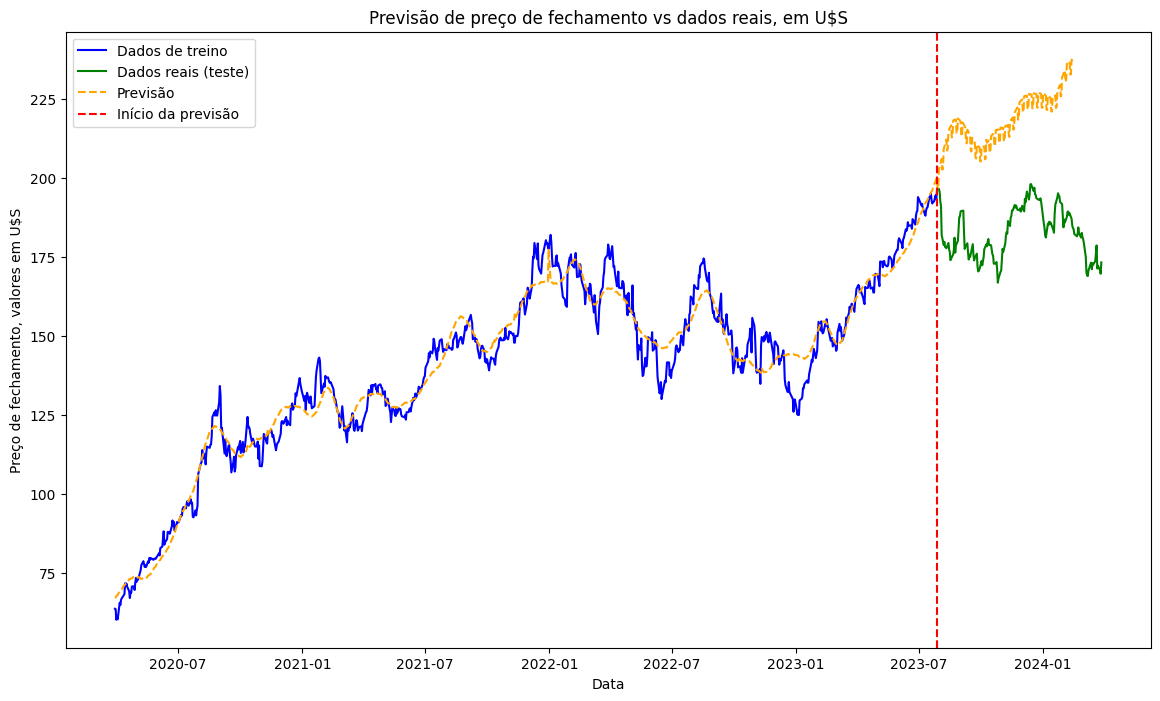

In [15]:
# Plotar os dados de treino, teste e previsões
plt.figure(figsize=(14, 8))
plt.plot(dados_treino['Date'], dados_treino['Close'], label='Dados de treino', color='blue')
plt.plot(dados_teste['Date'], dados_teste['Close'], label='Dados reais (teste)', color='green')
plt.plot(previsao['ds'], previsao['yhat'], label='Previsão', color='orange', linestyle='--')

plt.axvline(dados_treino['Date'].max(), color='red', linestyle='--', label='Início da previsão')
plt.xlabel('Data')
plt.ylabel('Preço de fechamento, valores em U$S')
plt.title('Previsão de preço de fechamento vs dados reais, em U$S')
plt.legend()
plt.show()

Esses gráficos são também muito utilizados para previsão de demanda (venda), em que existem informações tanto de estoque quanto da quantidade vendida nos dias (semanas, meses, anos etc.) anteriores - claro que dependendo do tipo de empresa e do tipo de dado armazenado.